# This notebook demonstrates how to determine the "optimal" radius for your observation.

Here, we define it as being the radius which maximizes the signal to noise based on a simple model of the background (e.g., that it is radially flat). This is mostly true on small spatial scales.

Please note that becuase the relative strength of the source to the background in the images is changing, using the full bandpass to determine the optimal radius will provide the optimal radius for the low energy spectral bands. The example below demonstrates this.

[nustar-gen-utils](https://nustar-gen-utils.readthedocs.io/en/latest) has a number of convenience wrappers in the `radial profile` module to help both with identifying the source location and for determining the optimal radius. Below shows an example based on a bright point source. There are any number of alternative tools in the literature that we encourage you to explore.

In [1]:
from nustar_gen.radial_profile import find_source, make_radial_profile, optimize_radius_snr
from nustar_gen.wrappers import make_image

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np

import regions
import astropy.units as u

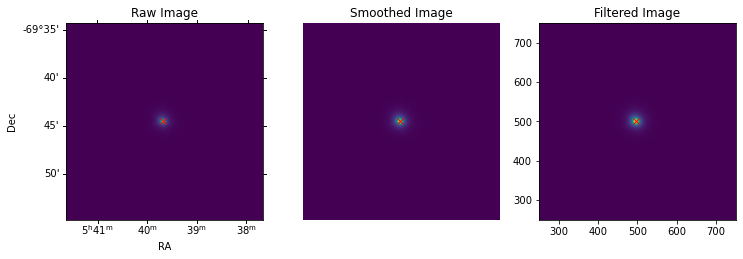

In [2]:
infile = 'example_data/30001039002/event_cl/nu30001039002A01_cl.evt'
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
coordinates = find_source(full_range, show_image = True, filt_range=3)

In [3]:
# Get the WCS header and convert the pixel coordinates into an RA/Dec object
hdu = fits.open(full_range, uint=True)[0]
wcs = WCS(hdu.header)

# The "flip" is necessary to go to [X, Y] ordering from native [Y, X] ordering, which wcs seems to require
world = wcs.all_pix2world(np.flip(coordinates), 0)
ra = world[0][0]
dec = world[0][1]
target = SkyCoord(ra, dec, unit='deg', frame='fk5')
print(target)
obj_j2000 = SkyCoord(hdu.header['RA_OBJ'], hdu.header['DEC_OBJ'], unit = 'deg', frame ='fk5')

# How far are we from the J2000 coordinates? If <15 arcsec, all is okay
sep = target.separation(obj_j2000)
print(sep)


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (84.91873214, -69.74221565)>
0d00m09.35958579s


In [4]:
# Now the radial image parts.

# Make the radial image for the full energy range (or whatever is the best SNR)
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
rind, rad_profile, radial_err, psf_profile = make_radial_profile(full_range, show_image=False,
                                                                 coordinates = coordinates)

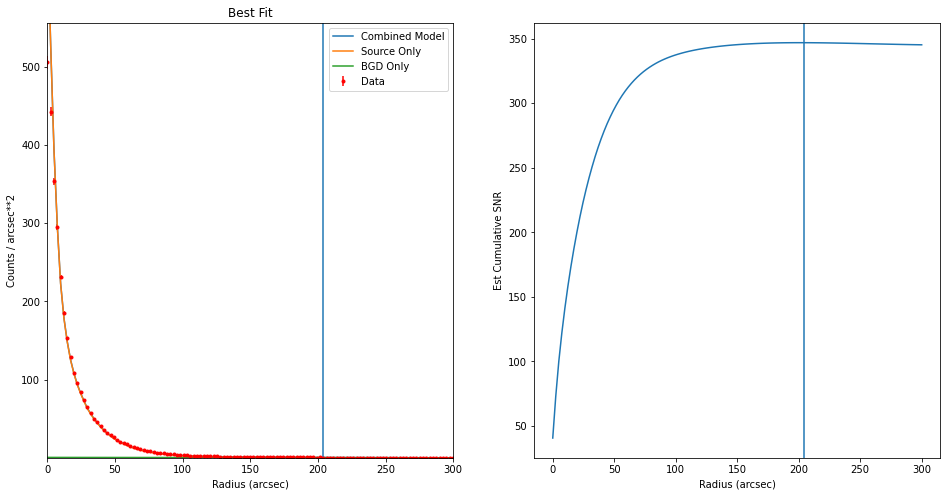

Radius of peak SNR for 3 to 20 keV: 204.02291088


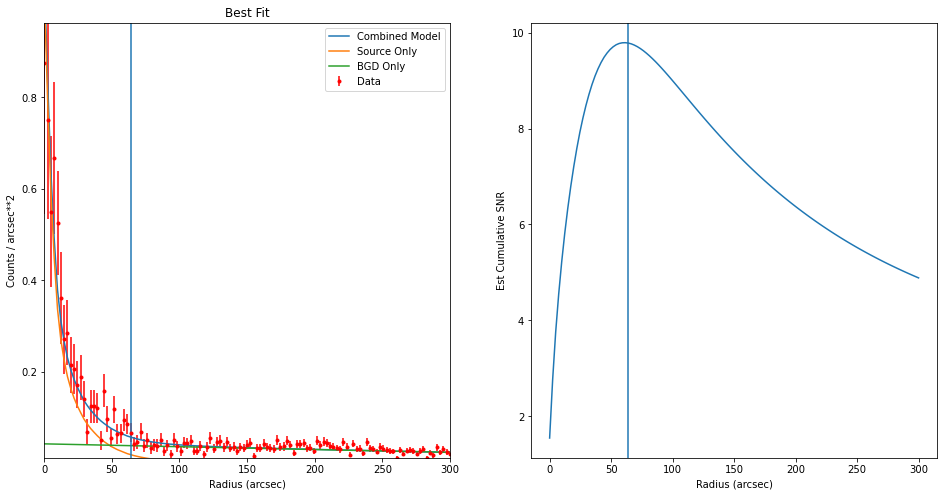

Radius of peak SNR for 20 to 30 keV: 63.910791360000005


/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


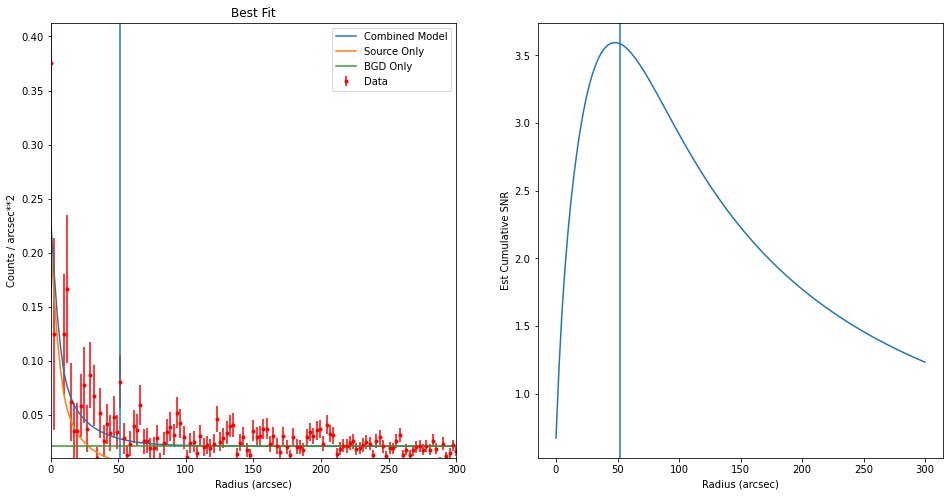

Radius of peak SNR for 30 to 40 keV: 51.62025456


/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


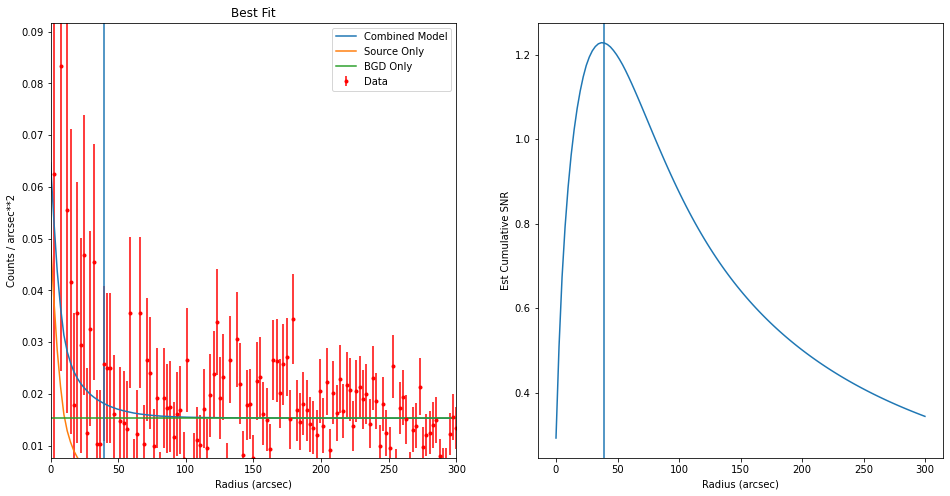

Radius of peak SNR for 40 to 50 keV: 39.32971776


/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/bwgref/science/local/src/miniconda3/envs/nustar/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


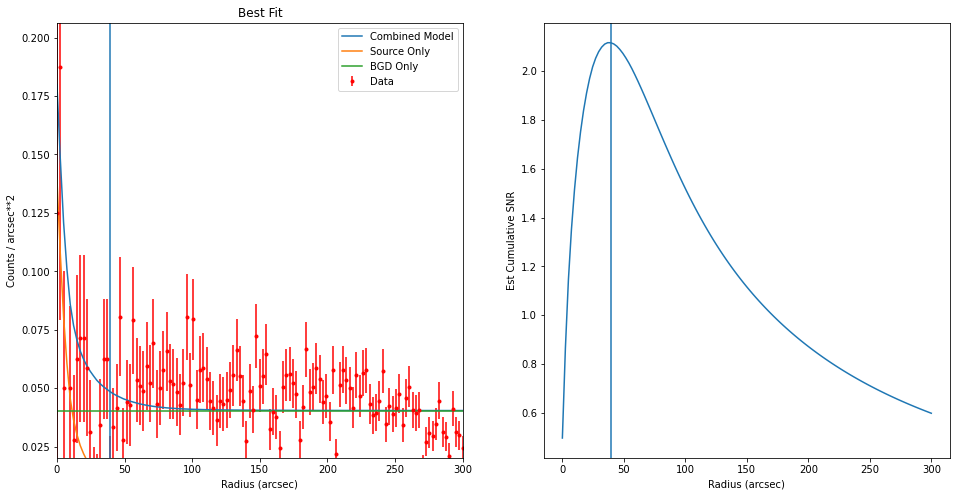

Radius of peak SNR for 50 to 80 keV: 39.32971776


In [5]:
# Pick energy ranges that you want to check.

# Note that this formalism breaks down when the source isn't detected, so use your best judgement here.

# Below should be used as a "best guess" when choosing a radius for spectral extraction.

# For the 3-20 keV case, the source dominates out the edge of the FoV (and the assumptoons about the PSF
# start to break down in the fit).

# This a soft source (LMC X-1), so for 20-30 keV we already see that we need to restrict the radius that we
# use so that we're not just adding noise to the spectrum.

pairs = [[3, 20], [20, 30], [30, 40], [40, 50], [50, 80]]
coordinates = find_source(full_range, show_image = False)
for pair in pairs:
    test_file = make_image(infile, elow = pair[0], ehigh = pair[1], clobber=True)
    rind, rad_profile, radial_err, psf_profile = make_radial_profile(test_file, show_image=False,
                                                                     coordinates = coordinates)
    rlimit = optimize_radius_snr(rind, rad_profile, radial_err, psf_profile, show=True)
    print('Radius of peak SNR for {} to {} keV: {}'.format(
            pair[0], pair[1], rlimit))

In [6]:
source_reg = [regions.CircleSkyRegion(center=target, radius=60*u.arcsec)]
outfile = 'example_data/30001039002/event_cl/srcA01.reg'
regions.write_ds9(source_reg, outfile, radunit='arcsec', overwrite=True)

# Summary

In this case, the optimal radius for the 3-20 keV band is roughly 200-arcsec.

However, when considering only the 20-30 keV band, then the optimal radius shrinks to roughly 60-arcsec.

It's up to the user to determine if they want as many photons as possible in the soft band (e.g., for timing analysis) or if they want the best signal-to-noise in the hard band (e.g. to measure curvature in the spectrum).